# Back Propagation from Scratch

En esta sección se trabajará con los algoritmos que resuelven las redes neuronales *Feed Forward*, es decir, los algoritmos que encuentran valores óptimos para sus pesos. Para esto se implementará estos algoritmos desde 0 (*from scratch*) teniendo unicamente el apoyo de librerías para operaciones básicas como lo entrega **numpy**.

### a) Entrenar una red **FF**

In [24]:
#pasos inicializadores
#L = 3 #numero de capas (IMPORTANTE)
#S, A, A_der,E_salida,E_pesos = crear_arquitectura(3,2,3)
#WM = init(L,S)
FF = red_neuronal([3,3,2,1])
print FF.WM

xi = np.array([2,5,11])
yi = 2
forward_pass(xi,yi,FF.L,FF.WM, FF.A,FF.A_der,FF.S)
print FF.A[FF.L-3]
print FF.A[FF.L-2]
print FF.A[FF.L-1]
print yi

print "back"
backward_pass(xi,yi,FF.L,FF.WM,FF.A,FF.A_der,FF.S,FF.E_salida,FF.E_pesos)
print FF.WM

[array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]]), array([[ 0.],
       [ 0.]])]
[ 2  5 11]
[ 0.5  0.5]
[ 0.5]
2
back
[array([[-0.375 , -0.375 ],
       [-0.9375, -0.9375],
       [-2.0625, -2.0625]]), array([[-0.09375],
       [-0.09375]])]


In [36]:
import math
import numpy as np

epsilon =  1e-15

#----funcion de activacion y gradiente
def sigmoid(x):
    x = np.maximum(epsilon, x) #si x es muy pequeño
    return 1 / (1 + np.exp(-x))
        
def gradient_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

#---funcion de perdida y gradiente
def loss_function(y,ypred):
    #binary
    ypred = np.maximum(epsilon, ypred)
    return -1.0*( y*np.log(ypred) + np.subtract(1,y)*np.log(np.subtract(1,ypred)) ) 

    #error cuadratico
    #return np.pow(y-ypred,2)/2
def gradient_loss_function(y,ypred):
    #binary
    ypred = np.maximum(epsilon, ypred)
    return -1.0* ( y-ypred)/(ypred*np.subtract(1,ypred))
    
    #error cuadratico
    #return y-ypred

#funcion que crea la arquitectura y crea las matrices 
#necesarias para almacenar informacion
def crear_arquitectura(input_dim,H,O,L):
    # numero de neuronas por capa
    S = range(L)
    S[0] = input_dim #input
    S[1] = H #oculta
    S[2] = O #salida
    
    #inicializan matrices de salidas de neuronas
    A = range(L)
    A_der = range(L) 
    for l in range(0,L):
        A[l] = np.zeros(S[l]) #salida de capa l
        A_der[l] = A[l].copy()       #salida derivada de capa l
        
    #inicializa matrices que guardan derividas
    Error_salida = range(L)
    Error_peso = range(L)
    for l in range(0,L):
        Error_salida[l] = np.zeros(S[l]) # error salida de capa l
    for l in range(0,L-1):
        Error_peso[l] = np.zeros((S[l],S[l+1]))    
        
    return S,A,A_der, Error_salida, Error_peso

##### S es una lista
##### A y A_der es lista de arrays numpy
## A[l][s] la salida de la neurona "s" en la capa "l"
##### WM es lista de matrices 
## WM[l][s:,] los pesos de los valores que salen de la neurona "s" de la capa "l"
#### Error son listas de matrices que guardan las derivadas del error
#funcion de salida
#funcion de pesos
#Error[l][s] #capa l, neurona s

#inicializa pesos
def init(L,S): 
    WM = range(L-1)
    for l in range(0,L-1):
        WM[l] = np.zeros((S[l],S[l+1]))
    return WM  

#realiza un forward pass de un par (xi,yi)
def forward_pass(xi,yi,L,WM, A,A_der,S):
    A[0] = xi #inicializa el input
    for l in range(0,L-1): #por cada capa        
        for s in range(0,S[l+1]): #por cada neurona de la capa siguiente
            aux = np.dot( WM[l][:,s], A[l])
            A[l+1][s] = sigmoid(aux)
            A_der[l+1][s] = gradient_sigmoid(aux)

def backward_pass(xi,yi,L,WM,A,A_der,S, Error_salida,Error_peso,lr):
    #calcula el error en la ultima capa
    for s in range(0,S[L-1]): 
        if S[L-1] == 1: #una salida
            ypred = A[L-1][0]
            Error_salida[L-1][0] = gradient_loss_function(yi, ypred)
            Error_peso[L-2][:,0] = Error_salida[L-1][0] * (A_der[L-1][0] * A[L-2][0] )
        else:#arquitectura con multiples salidas
            ypred = A[L-1].copy()
            Error_salida[L-1][s] = gradient_loss_function(yi[s], ypred[s]) #para el caso en que sea vector
            Error_peso[L-2][:,s] = Error_salida[L-1][s] * (A_der[L-1][s] * A[L-2])
        #actualizar pesos en vector
        WM[L-2][:,s] = WM[L-2][:,s] - lr*Error_peso[L-2][:,s]
        
    #calcula el error recurisvamente
    for l in np.arange(L-2,0,-1): #desde la penultima capa hasta la segunda {L-2,1}
        for s in range(0,S[l]): #para cada neurona en la capa l
            Error_salida[l][s] = np.sum(Error_salida[l+1])
            Error_peso[l-1][:,s] =  Error_salida[l][s] * ( A_der[l][s] * A[l-1])
            
            #actualizar pesos en vector
            WM[l-1][:,s] = WM[l-1][:,s] - lr*Error_peso[l-1][:,s]

#estructura de red neuronal con sus atributos necesarios
class red_neuronal:
    def __init__(self,args):
        self.L = args[0]
        self.input_dim = args[1]
        self.H = args[2]
        self.O = args[3]
        self.S, self.A, self.A_der,self.E_salida,self.E_pesos = crear_arquitectura(
                                                                    self.input_dim,
                                                                    self.H,
                                                                    self.O,
                                                                    self.L
                                                                    )
        self.WM = init(self.L,self.S)          
        
    def entrenar(self,X,Y,lr,epochs):
        error_por_epoch = []
        for i in range(epochs): #criterio de parada
            error = []
            for xi,yi in zip(X,Y): #con sgd un ejemplo a la vez
                #actualizan las salidas
                forward_pass(xi,yi,self.L,self.WM, self.A,self.A_der,self.S)
                
                #medir el error
                ypred = self.A[self.L-1].copy()
                error.append(loss_function(yi,ypred))

                #actualizan los pesos
                backward_pass(xi,yi,self.L,self.WM,self.A,self.A_der,self.S,self.E_salida,self.E_pesos,lr)
            error_por_epoch.append( np.mean(error) )
        return error_por_epoch
                  
print "hola mundo"

hola mundo


cambiaon los indices ya que parto desde la capa 0, no 1

hablar de todos los argumentos de las funciones

### b) Predicciones con la red

In [18]:
#FF  = red ya entrenada
def predecir(X_test,y_test,FF):
    n_test = len(y_test)
    print "numero de ejemplos: ",n_test
    
    predicciones = []
    for xi,yi in zip(X_test,y_test): #para n_test ejemplos
        y_hat = forward_pass(xi,yi,FF.L,FF.WM, FF.A,FF.A_der,FF.S)
        predicciones.append(y_hat)
    return predicciones

analisis

### c) Probar programa creado

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
df = pd.read_csv(url, sep=r'\s+',header=None)
X_train = df.ix[:,0:6]
y_train = df.ix[:,7]
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

print X_train.shape
print y_train.shape

(210, 7)
(210,)


El dataset sobre el cual se probará el programa de una red neuronal *Feed Forward* es el de **seeds**, la tarea consta de clasificar un ejemplo como un tipo de semilla en específico (3 clases). Se consta de 7 atributos para lograr identificar a cuál tipo de semilla pertenece. La cantidad de ejemplos son 210.

In [37]:
def softmax(x):
    retorno = np.zeros(len(x))
    suma =0.0
    for i in x:
        suma+=np.exp(i)
    for i in range(len(x)):
        retorno[i] = np.exp(x[i])/suma
    return retorno
def gradient_softmax(x):
    return softmax(x)*(1-softmax(x))

def forward_pass(xi,yi,L,WM, A,A_der,S):
    A[0] = xi #inicializa el input
    for l in range(0,L-1): #por cada capa        
        for s in range(0,S[l+1]): #por cada neurona de la capa siguiente
            aux = np.dot( WM[l][:,s], A[l])
            A[l+1][s] = sigmoid(aux)
            A_der[l+1][s] = gradient_sigmoid(aux)
    A[L-1] = softmax(A[L-1])
    return A[L-1].copy()

Se añade la función de activación softmax a la última capa debido a que el problema de multiclases lo amerita.

In [38]:
#y en un hot vector
nuevo_df = pd.get_dummies(df,columns =[7])
casi_y = nuevo_df.ix[:,7:10]
y_hotvector = np.asarray(casi_y)
print y_hotvector.shape

#Creacion de la red FF
L = 3
input_dim = X_train.shape[1]
H = 32 #hidden
O = 3 #outpit
FF = red_neuronal([L,input_dim,H,O])
errores = FF.entrenar(X_train,y_hotvector,lr = 0.1 ,epochs = 100)

(210, 3)


En la celda anterior se entrena la red creada con 3 capas, 32 neuronas en la capa escondida y 3 neuronas en la capa de salida debido a que el problema es un problema de clasificación de 3 clases. La función de activación seleccionada anteriormente es la sigmoidal, esencial para problemas de clasificación. La función de pérdida es la ...
Se entrena la red con *learning rate* de ... y número de epochs ...

In [39]:
print predecir(X_train,y_hotvector ,FF)[:5]

numero de ejemplos:  210
[array([ 0.23687835,  0.39050865,  0.372613  ]), array([ 0.23291315,  0.38400886,  0.38307799]), array([ 0.23291315,  0.38400886,  0.38307799]), array([ 0.23291315,  0.38400886,  0.38307799]), array([ 0.23687835,  0.39050865,  0.372613  ])]


En la celda anterior se prueba que el programa anterior creado para hacer prediciones con la red neuronal creada funciona, entregando una predicción para cada valor del conjunto requerido.

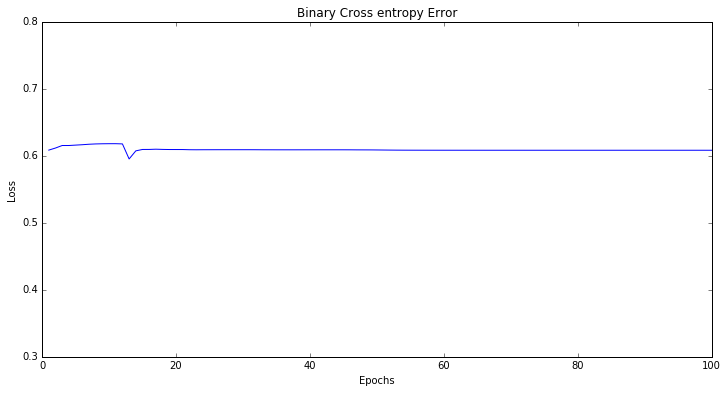

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title("Binary Cross entropy Error")
plt.plot(np.arange(1,101),errores)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.3,0.8)
plt.show()

asdasd la funcion obj es la misma que el error presentado, ya que no existe regularizacion

### d) weight decay

In [ ]:
#idea..
WM[l-1][:,s] = weight_decay * WM[l-1][:,s] - lr*Error_peso[l-1][:,s]
#actualizar weight decay